# micrograd - Test Notebook

This notebook imports the engine (Value) and neural network (Neuron, Layer, MLP) modules and runs several small problems to verify functionality:
- Basic Value arithmetic and backprop
- Testing pow and exp with numeric gradient check
- Graph visualization (if graphviz is installed)
- Train a tiny MLP on a toy dataset and plot training loss

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from engine import Value
from nn import Neuron, Layer, MLP
import threading
# deterministic randomness for reproducible tests
random.seed(42)

In [ ]:
# Optional: helper to draw computation graphs if graphviz is available
try:
    from graphviz import Digraph
    def trace(root):
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v._prev:
                    edges.add((child, v))
                    build(child)
        build(root)
        return nodes, edges

    def draw_dot(root):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        nodes, edges = trace(root)
        for n in nodes:
            uid = str(id(n))
            dot.node(name=uid, label='{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
            if n._op:
                dot.node(name=uid + n._op, label=n._op)
                dot.edge(uid + n._op, uid)
        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        return dot
except Exception as e:
    print('graphviz not available, draw_dot will raise on use:', e)
    def draw_dot(root):
        raise RuntimeError('graphviz not available')

## 1) Basic Value arithmetic and backprop

In [2]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a * b; c.label = 'c'
d = c + Value(1.0); d.label = 'd'
e = d.tanh(); e.label = 'e'
print('e.data =', e.data)
# backprop
e.backward()
print('a.grad =', a.grad)
print('b.grad =', b.grad)
print('d.grad =', d.grad)
# show graph if available
try:
    display(draw_dot(e))
except RuntimeError:
    pass

e.data = -0.9999092042625951
a.grad = -0.0005447496928315809
b.grad = 0.0003631664618877206
d.grad = 0.0001815832309438603


NameError: name 'draw_dot' is not defined

## 2) Test pow and exp with numeric gradient check

In [3]:
x = Value(3.0, label='x')
y = x**2 + x.exp(); y.label = 'y'
print('y.data =', y.data)
y.backward()
print('x.grad (autodiff) =', x.grad)
# numeric gradient (finite differences)
eps = 1e-6
def numeric_f(xv):
    return xv**2 + math.exp(xv)
num_grad = (numeric_f(3.0 + eps) - numeric_f(3.0 - eps)) / (2 * eps)
print('numeric grad =', num_grad)
print('difference =', abs(x.grad - num_grad))

y.data = 29.085536923187668
x.grad (autodiff) = 26.085536923187668
numeric grad = 26.085536926956365
difference = 3.7686973541894986e-09


## 3) Small MLP training (toy dataset)

epoch 0, loss = 5.230518
epoch 10, loss = 0.213094
epoch 20, loss = 0.084463
epoch 30, loss = 0.050164
epoch 40, loss = 0.034942
epoch 50, loss = 0.026500
epoch 60, loss = 0.021190
epoch 70, loss = 0.017565
epoch 79, loss = 0.015174
  sample 0: pred = 0.9371, label = 1.0
  sample 1: pred = -0.9605, label = -1.0
  sample 2: pred = -0.9206, label = -1.0
  sample 3: pred = 0.9442, label = 1.0
epoch 79, loss = 0.015174
  sample 0: pred = 0.9371, label = 1.0
  sample 1: pred = -0.9605, label = -1.0
  sample 2: pred = -0.9206, label = -1.0
  sample 3: pred = 0.9442, label = 1.0


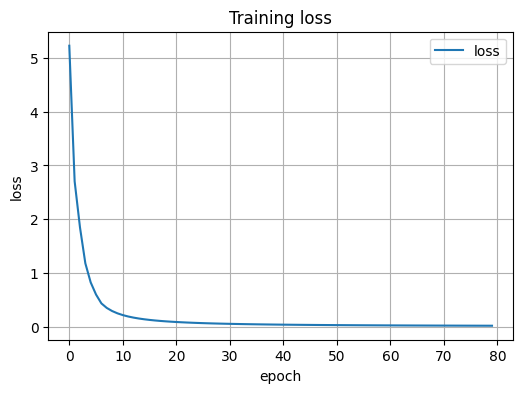

In [4]:
# toy dataset (same as in the example notebook)
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

net = MLP(3, [4, 4, 1])

# train and record loss history
loss_history = []
for epoch in range(80):
    ypred = [net(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    # zero grads
    for p in net.parameters():
        p.grad = 0.0
    loss.backward()
    # SGD step
    for p in net.parameters():
        p.data += -0.05 * p.grad
    loss_history.append(loss.data)
    if epoch % 10 == 0 or epoch == 79:
        print(f'epoch {epoch}, loss = {loss.data:.6f}')

# final predictions
ypred = [net(x) for x in xs]
for i, pred in enumerate(ypred):
    print(f'  sample {i}: pred = {pred.data:.4f}, label = {ys[i]}')

# plot loss
plt.figure(figsize=(6, 4))
plt.plot(loss_history, label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss')
plt.grid(True)
plt.legend()
plt.legend()

## 4) Finite-difference gradient check on a composite function

In [6]:
def finite_diff_grad(x0, f, eps=1e-6):
    return (f(x0 + eps) - f(x0 - eps)) / (2 * eps)

x0 = 0.7
def f_num(xv):
    return math.tanh(xv**2) - math.exp(xv)
# autodiff with our Value class
x = Value(x0, label='x')
y = (x**2).tanh() - x.exp()
y.backward()
print('y.data =', y.data)
print('autodiff dx =', x.grad)
print('finite-diff dx =', finite_diff_grad(x0, f_num))

y.data = -1.5595362747882175
autodiff dx = -0.9025903022765127
finite-diff dx = -0.9025903022763515


# Interactive function-approximation demo (degree ≤ 3)

This section lets you draw a single-valued function y = f(x) directly with the mouse, converts the drawing into a training dataset, and fits a degree-3 polynomial using the micrograd Value implementation. Training uses Mean Squared Error (MSE) plus optional L2 regularization to encourage smooth coefficients. Click and drag on the plot to draw; use the buttons to clear or fit the function. Training is animated and the loss is shown in real time.

## Loss formulation

We minimize Mean Squared Error over sampled points from your drawing:
L_mse = (1/N) * sum_i (y_pred(x_i) - y_i)^2

We optionally add an L2 regularization term on the polynomial coefficients to discourage extreme values:
L = L_mse + lambda * (a3^2 + a2^2 + a1^2 + a0^2)

All operations are built from micrograd.Value so gradients are computed by our autodiff implementation.

Using matplotlib backend: widget. For smoother interactive drawing install ipympl (pip install ipympl) and enable notebook widgets.


Label(value='Draw on the plot, then press Fit Function')

Output()

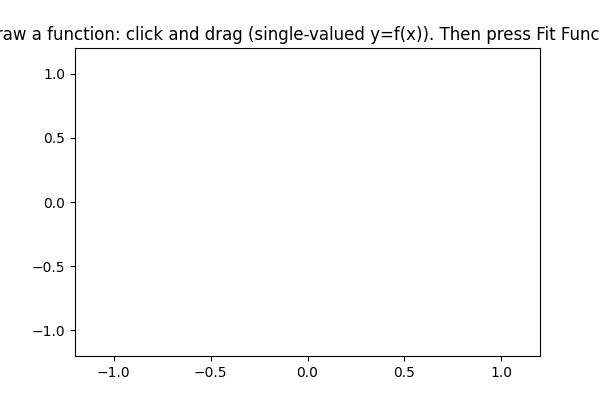

In [ ]:
# Interactive drawing and training code
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

# Try to enable interactive matplotlib backend if available for smoother drawing; fall back to inline
try:
    # prefer the 'widget' backend (requires ipympl)
    get_ipython().run_line_magic('matplotlib', 'widget')
    backend_used = 'widget'
except Exception:
    try:
        # older notebook interactive backend
        get_ipython().run_line_magic('matplotlib', 'notebook')
        backend_used = 'notebook'
    except Exception:
        # last resort: inline (static) plots
        get_ipython().run_line_magic('matplotlib', 'inline')
        backend_used = 'inline'
print(f'Using matplotlib backend: {backend_used}. For smoother interactive drawing install ipympl (pip install ipympl) and enable notebook widgets.')

# Containers for the drawing
draw_x, draw_y = [], []
is_drawing = {'val': False}

# Create the figure and interactive handlers
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Draw a function: click and drag (single-valued y=f(x)). Then press Fit Function')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
line_draw, = ax.plot([], [], color='black', linewidth=2)
scat_raw = ax.scatter([], [], color='black', s=10)

# store past fitted lines so they can be dimmed and distinguished
past_fits = []
# color cycle for past fits
color_cycle = plt.rcParams.get('axes.prop_cycle').by_key().get('color', ['C0','C1','C2','C3','C4','C5'])

# placeholder for polynomial annotation on the axes
poly_text = None

def on_press(event):
    if event.inaxes != ax:
        return
    is_drawing['val'] = True
    draw_x.append(event.xdata)
    draw_y.append(event.ydata)
    line_draw.set_data(draw_x, draw_y)
    scat_raw.set_offsets(np.column_stack([draw_x, draw_y]))
    fig.canvas.draw_idle()

def on_motion(event):
    if not is_drawing['val'] or event.inaxes != ax:
        return
    draw_x.append(event.xdata)
    draw_y.append(event.ydata)
    line_draw.set_data(draw_x, draw_y)
    scat_raw.set_offsets(np.column_stack([draw_x, draw_y]))
    fig.canvas.draw_idle()

def on_release(event):
    is_drawing['val'] = False

cid_press = fig.canvas.mpl_connect('button_press_event', on_press)
cid_move = fig.canvas.mpl_connect('motion_notify_event', on_motion)
cid_release = fig.canvas.mpl_connect('button_release_event', on_release)

# Widgets and output area
clear_btn = widgets.Button(description='Clear Drawing')
fit_btn = widgets.Button(description='Fit Function')
status = widgets.Label(value='Draw on the plot, then press Fit Function')
out = widgets.Output()

# Additional UI controls: learning rate, epochs, regularization
lr_slider = widgets.FloatSlider(value=0.1, min=1e-4, max=1.0, step=1e-3, description='lr')
epochs_box = widgets.IntText(value=200, description='epochs')
reg_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=1e-3, description='L2')
controls = widgets.HBox([lr_slider, epochs_box, reg_slider, fit_btn, clear_btn])
display(controls, status, out)

def clear_drawing(b=None):
    draw_x.clear()
    draw_y.clear()
    line_draw.set_data([], [])
    scat_raw.set_offsets(np.empty((0, 2)))
    fig.canvas.draw_idle()
    status.value = 'Drawing cleared'

def to_dataset(xlist, ylist, n_samples=200):
    # Convert freehand drawing into a single-valued function dataset.
    if len(xlist) == 0:
        return [], []
    xs = np.array(xlist)
    ys = np.array(ylist)
    # sort by x and remove NaNs
    mask = np.isfinite(xs) & np.isfinite(ys)
    xs = xs[mask]; ys = ys[mask]
    if len(xs) == 0:
        return [], []
    order = np.argsort(xs)
    xs = xs[order]; ys = ys[order]
    # bin into n_samples on the x-range and average y in each bin to make a function
    x_min, x_max = xs.min(), xs.max()
    if x_min == x_max:
        x_min -= 0.5; x_max += 0.5
    bins = np.linspace(x_min, x_max, n_samples)
    digitized = np.digitize(xs, bins)
    x_out = []
    y_out = []
    for i in range(1, len(bins)):
        mask = digitized == i
        if np.any(mask):
            x_out.append(xs[mask].mean())
            y_out.append(ys[mask].mean())
    return np.array(x_out), np.array(y_out)

# --- Use nn.MLP model from nn.py ---
def make_nn_model(hidden_sizes=[16]):
    # create an MLP taking 1 input and producing 1 output using the provided nn.py implementation
    sizes = hidden_sizes + [1]
    net = MLP(1, sizes)
    def predict(x):
        xv = Value(float(x))
        return net([xv])
    return net, predict

def compute_loss_from_net(net, predict, xs_np, ys_np, l2_lambda=0.0):
    N = len(xs_np)
    if N == 0:
        return Value(0.0)
    losses = []
    for xi, yi in zip(xs_np, ys_np):
        ypred = predict(xi)
        tgt = Value(float(yi))
        losses.append((ypred - tgt)**2)
    mse = sum(losses) * (1.0 / N)
    if l2_lambda > 0.0:
        params = net.parameters()
        reg = sum((p * p) for p in params)
        return mse + reg * l2_lambda
    return mse

def fit_pressed(b=None):
    status.value = 'Preparing data...'; out.clear_output()
    xs_train, ys_train = to_dataset(draw_x, draw_y, n_samples=200)
    if len(xs_train) == 0:
        status.value = 'No drawing to fit. Draw a function first.'
        return

    # dim previous past_fits so they don't compete with the new bright curve
    for i, old_line in enumerate(past_fits):
        try:
            old_line.set_alpha(0.12)  # very dim
            old_line.set_linewidth(1.0)
            old_line.set_zorder(1)
            old_line.set_color('gray')
        except Exception:
            pass

    # build network using nn.py (small network sufficient for smooth functions)
    net, predict = make_nn_model(hidden_sizes=[12])
    params = net.parameters()
    lr = float(lr_slider.value)
    epochs = int(epochs_box.value)
    l2 = float(reg_slider.value)

    # prepare line for continuous prediction
    line_x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 400)
    # create a bright/current plot that will be updated by the animation on the main thread
    pred_line_plot, = ax.plot([], [], color='red', linewidth=2.5, alpha=0.95, zorder=5, label='current fit')
    loss_history = []

    # shared state between worker and animation
    train_state = {'running': True, 'epoch': 0, 'loss': None, 'y_line': np.zeros_like(line_x)}

    # disable buttons while training
    fit_btn.disabled = True
    clear_btn.disabled = True
    status.value = 'Training...'; fig.canvas.draw_idle()

    def train_worker():
        try:
            for epoch in range(epochs):
                # zero grads on params
                for p in params:
                    p.grad = 0.0
                loss = compute_loss_from_net(net, predict, xs_train, ys_train, l2_lambda=l2)
                loss.backward()
                # SGD step
                for p in params:
                    p.data += -lr * p.grad
                loss_history.append(loss.data)

                # update shared y_line and loss (create new list to avoid mutation issues)
                y_line = np.array([predict(xi).data for xi in line_x])
                train_state['y_line'] = y_line
                train_state['loss'] = loss.data
                train_state['epoch'] = epoch + 1

                # small sleep to yield CPU so animation can update
                time.sleep(0.001)

            # training done
            train_state['running'] = False
            train_state['loss'] = loss_history[-1] if len(loss_history) else None

        finally:
            pass

    # animation callback runs on the main thread and updates the plot from train_state
    from matplotlib import animation
    anim = None

    def anim_update(frame):
        # if there's data from the worker, use it
        y_line = train_state.get('y_line')
        if y_line is not None:
            pred_line_plot.set_data(line_x, y_line)
        loss_val = train_state.get('loss')
        epoch_val = train_state.get('epoch', 0)
        if loss_val is not None:
            status.value = f'epoch {epoch_val}/{epochs}, loss={loss_val:.6f}'
        # when training finished, finalize and stop animation
        if train_state.get('running') is False:
            # copy final curve into faded past_fits
            try:
                final_y = train_state.get('y_line', np.zeros_like(line_x))
                col = color_cycle[len(past_fits) % len(color_cycle)]
                faded_line, = ax.plot(line_x, final_y, color=col, linewidth=1.25, alpha=0.22, zorder=2)
                past_fits.append(faded_line)
            except Exception:
                pass
            # compute a degree-3 polynomial approximation to the final curve and display it
            try:
                if np.any(final_y):
                    # fit cubic polynomial: coeffs are [a3, a2, a1, a0]
                    coeffs = np.polyfit(line_x, final_y, 3)
                    # format polynomial string
                    def fmt_coef(c):
                        return f'{c:.4g}'
                    a3, a2, a1, a0 = coeffs
                    poly_terms = []
                    poly_terms.append(f'{fmt_coef(a3)}*x**3')
                    poly_terms.append(f'{fmt_coef(a2)}*x**2')
                    poly_terms.append(f'{fmt_coef(a1)}*x')
                    poly_terms.append(f'{fmt_coef(a0)}')
                    poly_str = ' + '.join(poly_terms)
                    # update status and output area with the polynomial
                    status.value = f'Training complete — approx poly: {poly_str}'
                    with out:
                        clear_output(wait=True)
                        print('Degree-3 polynomial fit (highest->lowest):')
                        print(f'  a3, a2, a1, a0 = {a3:.6g}, {a2:.6g}, {a1:.6g}, {a0:.6g}')
                        print('Polynomial:', poly_str)
                    # annotate on the plot (remove previous annotation if present)
                    try:
                        global poly_text
                        if poly_text is not None:
                            try:
                                poly_text.remove()
                            except Exception:
                                pass
                        x_min, x_max = ax.get_xlim()
                        y_min, y_max = ax.get_ylim()
                        poly_text = ax.text(x_min + 0.02*(x_max-x_min), y_max - 0.06*(y_max-y_min), poly_str, fontsize=9, bbox=dict(facecolor='white', alpha=0.8), zorder=10)
                    except Exception:
                        pass
            except Exception:
                # if polyfit or display fails, still continue gracefully
                pass
            # remove bright realtime line
            try:
                pred_line_plot.remove()
            except Exception:
                pass
            # re-enable buttons
            fit_btn.disabled = False
            clear_btn.disabled = False
            # if not already set by poly display, set a default completion message
            if not status.value.startswith('Training complete'):
                status.value = 'Training complete'
            # stop the animation by returning None (FuncAnimation will continue, but we can clear it)
            return pred_line_plot,
        return pred_line_plot,

    # start training in a background thread
    thread = threading.Thread(target=train_worker, daemon=True)
    thread.start()

    # create animation that pulls data from the shared train_state
    anim = animation.FuncAnimation(fig, anim_update, interval=40)
    # keep a reference so it's not garbage-collected
    pred_line_plot._anim_ref = anim

    # no blocking; animation handles UI updates on the main thread

# hook up buttons
clear_btn.on_click(clear_drawing)
fit_btn.on_click(fit_pressed)